In [1]:
train_dir = './log/log_train.txt'
test_dir = './log/log_test.txt'

In [2]:
import re
import pandas as pd

In [3]:
a = 'DFL-CNN <==> Test <==> Epoch: [   0] Top1:5.667% Top5:30.667%'
re.findall(r'[0-9]+\.?[0-9]*',a)

['0', '1', '5.667', '5', '30.667']

In [67]:
a = '1.1'
float(a)

1.1

In [68]:
flag = 1
batch = []
epoch = []
loss = []
loss1 = []
loss2 = []
loss3 = []
acc_1 = []
acc_5 = []
for line in open(train_dir,"r"):
    if flag % 3 == 1:
        result = re.findall(r'[0-9]+\.?[0-9]*',line)
        epoch.append(int(result[0]))
        batch.append(int(result[1]))
    elif flag %3 == 2:
        result = re.findall(r'[0-9]+\.?[0-9]*',line)
        loss.append(float(result[0]))
        loss1.append(float(result[3]))
        loss2.append(float(result[6]))
        loss3.append(float(result[9]))
    else :
        result = re.findall(r'[0-9]+\.?[0-9]*',line)
        acc_1.append(float(result[1]))
        acc_5.append(float(result[3]))
    flag += 1

In [69]:
flag

3871

In [70]:
df = pd.DataFrame({'epoch':epoch, 'batch':batch,
                  'loss':loss, 'loss1':loss1, 'loss2':loss2, 'loss3':loss3,
                  'acc_1':acc_1, 'acc_5':acc_5})

In [71]:
df.head()

,epoch,batch,loss,loss1,loss2,loss3,acc_1,acc_5
0,0,0,7.2844,3.3825,3.5619,3.4000,3.571,14.286
1,0,1,7.3242,3.4107,3.5726,3.4087,4.464,16.964
2,0,2,7.3015,3.4091,3.5532,3.3915,4.762,18.452
3,0,3,7.2941,3.3928,3.5618,3.3956,4.464,19.196
4,0,4,7.3631,3.4770,3.5440,3.4214,4.643,18.571


In [72]:
df.to_csv('train_log_1.csv',index = False)

In [73]:
t1 = []
t5 = []
epoch = []
for line in open(test_dir, 'r'):
    result = re.findall(r'[0-9]+\.?[0-9]*',line)
    epoch.append(int(result[0]))
    t1.append(float(result[2]))
    t5.append(float(result[4]))
df2 = pd.DataFrame({'epoch':epoch, 'top-1':t1, 'top-5':t5})

In [74]:
df2.head()

,epoch,top-1,top-5
0,0,11.333,35.333
1,2,20.333,54.000
2,4,24.000,58.667
3,6,28.333,65.333
4,8,31.667,76.000


In [75]:
df2.to_csv('test_log_1.csv',index=False)

In [76]:
summerize = df.groupby(df['epoch']).agg('mean')

In [77]:
import matplotlib.pyplot as plt

In [78]:
summerize.head()

,batch,loss,loss1,loss2,loss3,acc_1,acc_5
epoch,,,,,,,
0,21,7.159251,3.368547,3.450335,3.403721,5.004837,19.955651
1,21,6.939698,3.218716,3.380770,3.402119,11.163791,38.794721
2,21,6.813121,3.127912,3.345009,3.402114,18.899093,49.532767
3,21,6.697088,3.059247,3.297826,3.400079,21.977023,54.532349
4,21,6.591316,3.014626,3.236765,3.399342,22.597256,56.062953


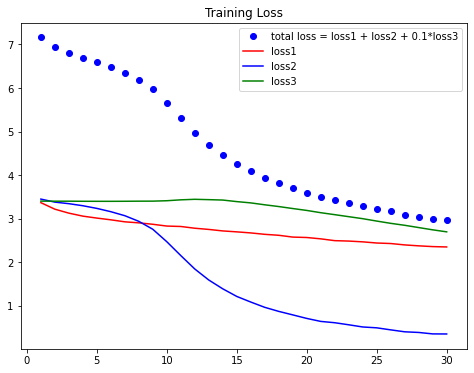

In [80]:
plt.figure(figsize = (8,6))
epochs = range(1, 31)
plt.plot(epochs, summerize['loss'], 'bo', label = 'total loss = loss1 + loss2 + 0.1*loss3')
plt.plot(epochs, summerize['loss1'], 'r', label = 'loss1')
plt.plot(epochs, summerize['loss2'], 'b', label = 'loss2')
plt.plot(epochs, summerize['loss3'], 'g', label = 'loss3')
plt.title('Training Loss')
plt.legend() # 添加图例
plt.savefig("Training Loss new.png")
plt.show()

In [81]:
max_1 = max(summerize['acc_1'])
l_max_1 = 'Best train top1 Acc = {:.2f}'.format(max_1)
max_5 = max(summerize['acc_5'])
l_max_5 = 'Best train top5 Acc = {:.2f}'.format(max_5)
max1 = max(df2['top-1'])
l_max1 = 'Best test top1 Acc = {:.2f}'.format(max1)
max5 = max(df2['top-5'])
l_max5 = 'Best test top5 Acc = {:.2f}'.format(max5)

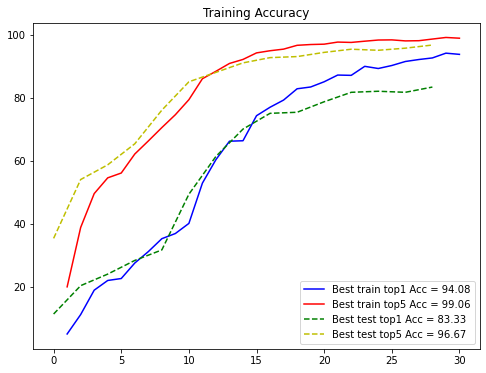

In [82]:
plt.figure(figsize = (8,6))
epochs = range(1, 31)
plt.plot(epochs, summerize['acc_1'], 'b', label = l_max_1)
plt.plot(epochs, summerize['acc_5'], 'r', label = l_max_5)
plt.plot(df2['epoch'], df2['top-1'], 'g', label = l_max1, linestyle = '--')
plt.plot(df2['epoch'], df2['top-5'], 'y', label = l_max5, linestyle = '--')
# plt.plot([0,25],[max_1, max_1],'dodgerblue', label = l_max_1, linestyle = '--')
# plt.plot([0,25],[max_5, max_5],'coral', label = l_max_5, linestyle = '--')

plt.title('Training Accuracy')
plt.legend() # 添加图例
plt.savefig("Training Accuracy new.png")
plt.show()

## 模型部署

In [1]:
import torch
model = torch.load('./log/model_best.pth.tar', map_location='cpu')

In [2]:
from utils.transform import *
from utils.MyImageFolderWithPaths import *
transform_train = get_transform_for_train()
train_dataset = ImageFolderWithPaths('../data/train', transform = transform_train)

In [3]:
import torchvision
vgg16featuremap = torchvision.models.vgg16_bn(pretrained=True)

In [4]:
list(vgg16featuremap.features.children())[:-11]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU

In [5]:
from model.DFL import DFL_VGG16
import torch.nn as nn

model = DFL_VGG16(k = 10, nclass = 30) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.000005)
checkpoint = torch.load('./log/model_best.pth.tar', map_location='cpu')

In [6]:
import collections
ckpt_new = collections.OrderedDict()

In [7]:
for layer in checkpoint['state_dict'].keys():
    ckpt_new[layer[7:]] = checkpoint['state_dict'][layer]

In [8]:
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
model.load_state_dict(ckpt_new)
optimizer.load_state_dict(checkpoint['optimizer'])

In [12]:
ckpt_new.keys()

odict_keys(['conv1_conv4.0.weight', 'conv1_conv4.0.bias', 'conv1_conv4.1.weight', 'conv1_conv4.1.bias', 'conv1_conv4.1.running_mean', 'conv1_conv4.1.running_var', 'conv1_conv4.1.num_batches_tracked', 'conv1_conv4.3.weight', 'conv1_conv4.3.bias', 'conv1_conv4.4.weight', 'conv1_conv4.4.bias', 'conv1_conv4.4.running_mean', 'conv1_conv4.4.running_var', 'conv1_conv4.4.num_batches_tracked', 'conv1_conv4.7.weight', 'conv1_conv4.7.bias', 'conv1_conv4.8.weight', 'conv1_conv4.8.bias', 'conv1_conv4.8.running_mean', 'conv1_conv4.8.running_var', 'conv1_conv4.8.num_batches_tracked', 'conv1_conv4.10.weight', 'conv1_conv4.10.bias', 'conv1_conv4.11.weight', 'conv1_conv4.11.bias', 'conv1_conv4.11.running_mean', 'conv1_conv4.11.running_var', 'conv1_conv4.11.num_batches_tracked', 'conv1_conv4.14.weight', 'conv1_conv4.14.bias', 'conv1_conv4.15.weight', 'conv1_conv4.15.bias', 'conv1_conv4.15.running_mean', 'conv1_conv4.15.running_var', 'conv1_conv4.15.num_batches_tracked', 'conv1_conv4.17.weight', 'conv1_co

In [10]:
model

DFL_VGG16(
  (conv1_conv4): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d

In [19]:
model.cls6[0]

Conv2d(300, 30, kernel_size=(1, 1), stride=(1, 1))

In [5]:
from utils.transform import *
def get_transform():
    transform_list = []
    
    transform_list.append(transforms.Lambda(lambda img:scale_keep_ar_min_fixed(img, 448)))
    
    #transform_list.append(transforms.RandomHorizontalFlip(p=0.3))
    
    transform_list.append(transforms.CenterCrop((448, 448)))
    
    transform_list.append(transforms.ToTensor())
    
    transform_list.append(transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)))
    
    return transforms.Compose(transform_list)

def transform_onlysize():
    transform_list = []
    transform_list.append(transforms.Resize(448))
    transform_list.append(transforms.CenterCrop((448, 448)))
    transform_list.append(transforms.Pad((42, 42)))
    return transforms.Compose(transform_list)

In [32]:
#path_img = '../data/val/Eurofighter/2189411.jpg'
path_img = './vis-img/boeing.jpg'

In [3]:
index2classlist = train_dataset.index2classlist()

In [4]:
index2classlist

['ATR',
 'Airbus',
 'Antonov',
 'Beechcraft',
 'Boeing',
 'Bombardier Aerospace',
 'British Aerospace',
 'Canadair',
 'Cessna',
 'Cirrus Aircraft',
 'Dassault Aviation',
 'Dornier',
 'Douglas Aircraft Company',
 'Embraer',
 'Eurofighter',
 'Fairchild',
 'Fokker',
 'Gulfstream Aerospace',
 'Ilyushin',
 'Lockheed Corporation',
 'Lockheed Martin',
 'McDonnell Douglas',
 'Panavia',
 'Piper',
 'Robin',
 'Saab',
 'Supermarine',
 'Tupolev',
 'Yakovlev',
 'de Havilland']

##### BBox

In [33]:
from PIL import Image, ImageFont, ImageDraw

transform1 = get_transform()       # transform for predict 
transform2 = transform_onlysize()  # transform for draw
img = Image.open(path_img)
img_pad = transform2(img)
img_tensor = transform1(img)
img_tensor = img_tensor.unsqueeze(0)
out1, out2, out3, indices = model(img_tensor)
out = out1 + out2 + 0.1 *out3

In [25]:
import numpy as np

In [34]:
value, index = torch.max(out.cpu(), 1)
vrange = np.arange(0, 10)  
# select from index - index+9 in 2000
# in test I use 1st class, so I choose indices[0, 9] 
for i in vrange:
    indice = indices[0, i]
    row, col = indice/56, indice%56
    p_tl = (8*col, 8*row)
    p_br = (col*8+92, row*8+92)
    draw = ImageDraw.Draw(img_pad)
    draw.rectangle((p_tl, p_br), outline='red')
    
idx = int(index[0])
dirname = index2classlist[idx]

filename = 'boeing_bbox_'+ dirname +'.jpg'
filepath = os.path.join('CAM',filename)
img_pad.save(filepath, "JPEG") 

In [29]:
import numpy as np
out = out1 + out2 + 0.1 *out3

value, index = torch.max(out.cpu(), 1)
vrange = np.arange(0, 10)

In [31]:
idx = int(index[0])

In [36]:
for i in vrange:
    indice = indices[0, i]
    row, col = indice/56, indice%56
    p_tl = (8*col, 8*row)
    p_br = (col*8+92, row*8+92)
    draw = ImageDraw.Draw(img_pad)
    draw.rectangle((p_tl, p_br), outline='red')
filename = index2classlist[idx] + '_try.jpg'
img_pad.save(filename, "JPEG")

In [51]:
model.conv5[7]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [53]:
model.conv6

Conv2d(512, 300, kernel_size=(1, 1), stride=(1, 1))

##### CAM

In [23]:
#FUNCTION
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)
    
def cam_show_img(img, feature_map, grads, out_dir, fname):
    H, W, _ = img.shape
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)  # 4
    grads = grads.reshape([grads.shape[0], -1])  # 5
    weights = np.max(grads, axis=1)  # 6
    for i, w in enumerate(weights):
        cam += w * feature_map[i, :, :]  # 7
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (W, H))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_img = 0.3 * heatmap + 0.7 * img

    path_cam_img = os.path.join(out_dir, fname)
    cv2.imwrite(path_cam_img, cam_img)
    return cam_img

In [8]:
import cv2
import numpy as np

In [24]:
numm = 5
model = DFL_VGG16(k = 10, nclass = 30) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.000005)
checkpoint = torch.load('./log/model_best.pth.tar', map_location='cpu')
ckpt_new = collections.OrderedDict()
for layer in checkpoint['state_dict'].keys():
    ckpt_new[layer[7:]] = checkpoint['state_dict'][layer]
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
model.load_state_dict(ckpt_new)
optimizer.load_state_dict(checkpoint['optimizer'])
transform1 = get_transform()

#path_img = '../data/val/Eurofighter/2189411.jpg'
path_img = './vis-img/'+str(numm)+'.jpg'

img = Image.open(path_img)
img_ = cv2.imread(path_img, 1)
img_tensor = transform1(img)
img_tensor = img_tensor.unsqueeze(0)

fmap_block = list()
grad_block = list()
model.eval()

model.conv5[7].register_forward_hook(farward_hook)
model.conv5[7].register_backward_hook(backward_hook)

out1, out2, out3, indices = model(img_tensor)
out = out1 + out2 + 0.1 *out3
value, index = torch.max(out.cpu(), 1)
idx = int(index[0])
model.zero_grad()

size = out[0, idx].shape
loss_total = torch.empty(size)
loss_total += out[0, idx]
loss_total.backward()
grads_val = grad_block[0].cpu().data.numpy().squeeze()
fmap = fmap_block[0].cpu().data.numpy().squeeze()

name = index2classlist[idx] +'_'+str(numm)+'_conv5.jpg'
cam_show_img(img_, fmap, grads_val, 'CAM', name)

C:\Users\lzl70\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


array([[[107. ,  53.9,  43.4],
        [107. ,  53.9,  43.4],
        [106.3,  53.2,  42.7],
        ...,
        [125.9,  65.8,  42.7],
        [125.9,  65.8,  42.7],
        [124.5,  66.5,  42.7]],

       [[106.3,  53.2,  42.7],
        [106.3,  53.2,  42.7],
        [106.3,  53.2,  42.7],
        ...,
        [126.6,  67.2,  42.7],
        [125.9,  66.5,  42. ],
        [124.5,  66.5,  42. ]],

       [[104.9,  53.2,  42.7],
        [104.9,  53.2,  42.7],
        [104.9,  53.2,  42.7],
        ...,
        [126.6,  67.9,  42. ],
        [124.5,  67.2,  41.3],
        [124.5,  66.5,  42. ]],

       ...,

       [[ 46.8,   1.4,   0. ],
        [ 89.5,  43.4,  33.6],
        [129.4,  80.5,  69.3],
        ...,
        [ 38.4,   0. ,   0. ],
        [ 38.4,   0. ,   0. ],
        [ 38.4,   0. ,   0. ]],

       [[ 38.4,   0.7,   4.2],
        [ 38.4,   0. ,   2.1],
        [ 39.1,   0.7,   0.7],
        ...,
        [ 38.4,   0. ,   0. ],
        [ 38.4,   0. ,   0. ],
        [ 38.4,

In [22]:
model.cls6

Sequential(
  (0): Conv2d(300, 30, kernel_size=(1, 1), stride=(1, 1))
  (1): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [25]:
numm = 4
model = DFL_VGG16(k = 10, nclass = 30) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.000005)
checkpoint = torch.load('./log/model_best.pth.tar', map_location='cpu')
ckpt_new = collections.OrderedDict()
for layer in checkpoint['state_dict'].keys():
    ckpt_new[layer[7:]] = checkpoint['state_dict'][layer]
start_epoch = checkpoint['epoch']
best_prec1 = checkpoint['best_prec1']
model.load_state_dict(ckpt_new)
optimizer.load_state_dict(checkpoint['optimizer'])
transform1 = get_transform()

#path_img = '../data/val/Eurofighter/2189411.jpg'
path_img = './vis-img/'+str(numm)+'.jpg'

img = Image.open(path_img)
img_ = cv2.imread(path_img, 1)
img_tensor = transform1(img)
img_tensor = img_tensor.unsqueeze(0)

fmap_block = list()
grad_block = list()
model.eval()

# model.conv5[7].register_forward_hook(farward_hook)
# model.conv5[7].register_backward_hook(backward_hook)

model.conv6.register_forward_hook(farward_hook)
model.conv6.register_backward_hook(backward_hook)

out1, out2, out3, indices = model(img_tensor)
out = out1 + out2 + 0.1 *out3
value, index = torch.max(out.cpu(), 1)
idx = int(index[0])
print(index2classlist[idx])

model.zero_grad()

size = out[0, idx].shape
loss_total = torch.empty(size)
loss_total += out[0, idx]
loss_total.backward()
grads_val = grad_block[0].cpu().data.numpy().squeeze()
fmap = fmap_block[0].cpu().data.numpy().squeeze()

name = index2classlist[idx] +'_'+str(numm)+'_conv6.jpg'
cam_show_img(img_, fmap, grads_val, 'log', name)

C:\Users\lzl70\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Dornier


array([[[211. , 142.8, 143.5],
        [211. , 142.8, 143.5],
        [211.7, 143.5, 144.2],
        ...,
        [200.1, 149.8, 151.9],
        [199.4, 149.1, 151.2],
        [199.4, 149.1, 151.2]],

       [[211. , 142.8, 143.5],
        [211. , 142.8, 143.5],
        [211.7, 143.5, 144.2],
        ...,
        [199.4, 149.1, 151.2],
        [199.4, 149.1, 151.2],
        [199.4, 149.1, 151.2]],

       [[211. , 142.8, 143.5],
        [211. , 142.8, 143.5],
        [211.7, 143.5, 144.2],
        ...,
        [199.4, 149.8, 149.8],
        [199.4, 149.8, 149.8],
        [198.7, 149.1, 149.1]],

       ...,

       [[ 70.8,   0. ,   0. ],
        [ 70.8,   0. ,   0. ],
        [249.3, 178.5, 178.5],
        ...,
        [185.5, 123.2, 121.1],
        [ 95.9,  35. ,  32.2],
        [ 61.6,   0.7,   0. ]],

       [[ 72.2,   1.4,   1.4],
        [ 70.8,   0. ,   0. ],
        [247.9, 177.1, 177.1],
        ...,
        [178.5, 116.2, 114.1],
        [112. ,  51.1,  48.3],
        [ 74.2,